In [31]:
import pandas as pd
import geopandas as gpd
import folium
import osmnx as ox
import zipfile
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.width', 1000)

In [32]:
CITY = "Potsdam, Germany"
SCHOOL_RADIUS = 250  # meters
JAHRE = [2020, 2021, 2022, 2023, 2024] #2019, 2016, 2017, 2018, 

In [33]:
def get_ufa(year: int) -> gpd.GeoDataFrame:
    with zipfile.ZipFile(f"../data/unfallatlas/Unfallorte{year}_EPSG25832_CSV.zip") as z:
        candidates = [n for n in z.namelist() if n.endswith(".txt") or n.endswith(".csv")]
        if not candidates:
            raise ValueError(f"No Unfallorte file found for year {year}")
        else:
            with z.open(candidates[0]) as f:
                df = pd.read_csv(f, sep=";", low_memory=False)
                df["XGCSWGS84"] = df["XGCSWGS84"].str.replace(",", ".")
                df["YGCSWGS84"] = df["YGCSWGS84"].str.replace(",", ".")
                df["XGCSWGS84"] = pd.to_numeric(df["XGCSWGS84"], errors="coerce")
                df["YGCSWGS84"] = pd.to_numeric(df["YGCSWGS84"], errors="coerce")
                gdf = gpd.GeoDataFrame(
                    df,
                    geometry=gpd.points_from_xy(df["XGCSWGS84"], df["YGCSWGS84"]),
                    crs="EPSG:4326",
                )
                gdf = gdf.to_crs("EPSG:25832")
                return gdf

def get_street_geometry_with_tempo(city: str, tempo: int) -> gpd.GeoDataFrame:
    tags = {"maxspeed": str(tempo)}
    gdf = ox.features_from_place(city, tags)
    gdf = gdf[gdf.geometry.type.isin(["LineString", "MultiLineString"])]
    gdf = gdf.to_crs("EPSG:25832")    
    return gdf

def get_schools(city: str) -> gpd.GeoDataFrame:
    file_path = "../data/schools/schulen_potsdam.csv"
    df = pd.read_csv(file_path, sep=";")
    df["latitude"] = pd.to_numeric(df["Geo Point"].str.split(",").str[0], errors="coerce")
    df["longitude"] = pd.to_numeric(df["Geo Point"].str.split(",").str[1], errors="coerce")
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )
    gdf = gdf.to_crs("EPSG:25832")
    return gdf

In [34]:
ufa = pd.concat([get_ufa(year) for year in JAHRE], ignore_index=True)
print(ufa[["UGEMEINDE", "ULAND", "UKREIS"]].head())
ufa = ufa[(ufa["ULAND"] == 12) & (ufa["UKREIS"] == 54) & (ufa["UGEMEINDE"] == 000)]
    
streets_tempo_30 = get_street_geometry_with_tempo(CITY, 30)
streets_tempo_50 = get_street_geometry_with_tempo(CITY, 50)
schools = get_schools(CITY)

   UGEMEINDE  ULAND  UKREIS
0        468     12      68
1        112     12      61
2        144     12      67
3         76     12      69
4        224     12      62


In [35]:
print(f"Loaded {len(schools)} schools")
print(schools.columns)
print(f"Loaded {len(ufa)} Unfallorte")
print(ufa.columns)

Loaded 81 schools
Index(['Geo Point', 'Geo Shape', 'Schulname', 'Schulnumme', 'Schulnum_1', 'Status', 'Standort', 'Strasse', 'Plz', 'Ort', 'X_E89_RBS', 'Y_E89_RBS', 'Planungsra', 'Sozialraum', 'Schulform_', 'Träger', 'latitude', 'longitude', 'geometry'], dtype='object')
Loaded 2981 Unfallorte
Index(['OBJECTID', 'UIDENTSTLAE', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE', 'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART', 'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84', 'STRZUSTAND', 'geometry', 'OID_', 'IstStrassenzustand', 'PLST'], dtype='object')


In [36]:
schools_buffered = schools.copy()
schools_buffered["geometry"] = schools_buffered.geometry.buffer(SCHOOL_RADIUS)

schools_near_50 = gpd.sjoin(
    schools_buffered,
    streets_tempo_50,
    how="inner",
    predicate="intersects",
)
ids_50 = schools_near_50.index.unique()
print(f"Schools near tempo 50 streets: {len(ids_50)}")

schools_near_30 = gpd.sjoin(
    schools_buffered,
    streets_tempo_30,
    how="inner",
    predicate="intersects",
)
ids_30 = schools_near_30.index.unique()
print(f"Schools near tempo 30 streets: {len(ids_30)}")

ids_30_not_50 = ids_30.difference(ids_50)
print(f"Schools near tempo 30 but not tempo 50 streets: {len(ids_30_not_50)}")

Schools near tempo 50 streets: 56
Schools near tempo 30 streets: 79
Schools near tempo 30 but not tempo 50 streets: 23


In [37]:
m = folium.Map(location=[52.3906, 13.0645], zoom_start=13)
schools_50 = schools.loc[ids_50].to_crs("EPSG:4326")
schools_30 = schools.loc[ids_30_not_50].to_crs("EPSG:4326")
for _, row in schools_50.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["Schulname"],
        icon=folium.Icon(color="red", icon="home"),
    ).add_to(m)
for _, row in schools_30.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["Schulname"],
        icon=folium.Icon(color="green", icon="home"),
    ).add_to(m)
# add tempo 30 streets in blue
for _, row in streets_tempo_30.to_crs("EPSG:4326").iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x: {"color": "green", "weight": 3},
    ).add_to(m)
# add tempo 50 streets in red
for _, row in streets_tempo_50.to_crs("EPSG:4326").iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda x: {"color": "red", "weight": 3},
    ).add_to(m)
m.save("../out/schools_map.html")

In [38]:
# compute are of CITY="Potsdam, Germany" with osmnx
area = ox.geocode_to_gdf(CITY).to_crs("EPSG:25832")
area_size = area.geometry.area.iloc[0]  # in square meters
print(f"Area of {CITY}: {area_size / 1_000_000:.2f} km²")

# unary of all buffered schools to get exact area covered
schools_union = schools_buffered.union_all()
total_school_area_no_overlap = schools_union.area
print(f"Total area covered by schools (no overlap): {total_school_area_no_overlap / 1_000_000:.2f} km²")
print(f"Percentage of area covered (no overlap): {total_school_area_no_overlap / area_size * 100:.2f}%")

Area of Potsdam, Germany: 188.40 km²
Total area covered by schools (no overlap): 11.38 km²
Percentage of area covered (no overlap): 6.04%


In [39]:
ufa["WEEKEND"] = ufa["UWOCHENTAG"].isin([0, 6])
ufa["SCHULZEIT"] = (ufa["USTUNDE"].between(7, 8) | ufa["USTUNDE"].between(13, 15)) & (~ufa["WEEKEND"])
ufa_near_schools = gpd.sjoin(
    ufa,
    schools_buffered,
    how="inner",
    predicate="intersects",
    lsuffix="ufa",
    rsuffix="school"
)
ufa_not_schools = ufa.drop(ufa_near_schools.index)

In [40]:
# durchscnittlich unfälle pro tag im jahr 2024 gesamt und in schulnähe
ufa_2024 = ufa[ufa["UJAHR"] == 2024]
ufa_2024_near_schools = ufa_near_schools[ufa_near_schools["UJAHR"] == 2024]
days_in_year = 366 if 2024 % 4 == 0 else 365
total_ufa_2024 = len(ufa_2024)
total_ufa_2024_near_schools = len(ufa_2024_near_schools)
print(f"Total accidents in 2024: {total_ufa_2024}, average per day: {total_ufa_2024 / days_in_year:.2f}")
print(f"Total accidents near schools in 2024: {total_ufa_2024_near_schools}, average per day: {total_ufa_2024_near_schools / days_in_year:.2f}")

Total accidents in 2024: 605, average per day: 1.65
Total accidents near schools in 2024: 244, average per day: 0.67


/tmp/ipykernel_358578/2394846903.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


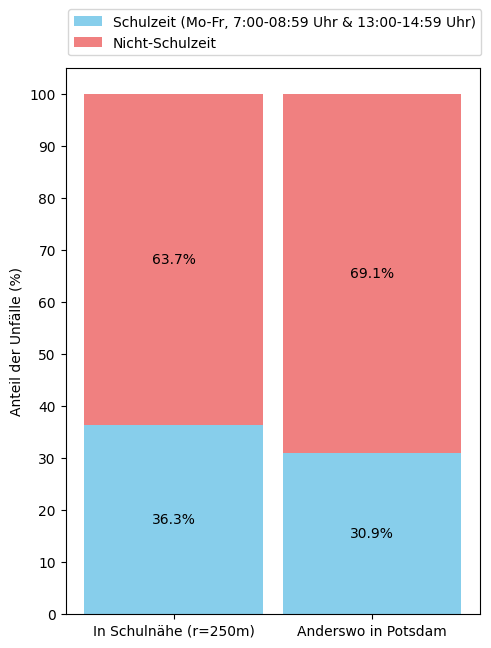

In [41]:
# make a stacked bar chart of relative amount of accidents during school time vs not during school time, within and outside school areas
school_time_counts = [
    ufa_near_schools["SCHULZEIT"].value_counts(normalize=True).get(True, 0) * 100,
    ufa_not_schools["SCHULZEIT"].value_counts(normalize=True).get(True, 0) * 100,
]
non_school_time_counts = [
    ufa_near_schools["SCHULZEIT"].value_counts(normalize=True).get(False, 0) * 100,
    ufa_not_schools["SCHULZEIT"].value_counts(normalize=True).get(False, 0) * 100,
]
x = np.arange(2)  # the label locations
width = 0.9  # the width of the bars
fig, ax = plt.subplots(figsize=(5, 6))
rects1 = ax.bar(x, school_time_counts, width, label='Schulzeit (Mo-Fr, 7:00-08:59 Uhr & 13:00-14:59 Uhr)', color='skyblue')
rects2 = ax.bar(x, non_school_time_counts, width, bottom=school_time_counts, label='Nicht-Schulzeit', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anteil der Unfälle (%)')
ax.set_xticks(x)
ax.set_xticklabels([f'In Schulnähe (r={SCHOOL_RADIUS}m)', 'Anderswo in Potsdam'])
ax.set_yticks(np.arange(0, 101, 10))
fig.tight_layout()
ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.12))  # (x, y) coordinates

# Add percentage text to the boxes
for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
    ax.text(
        rect1.get_x() + rect1.get_width() / 2,
        rect1.get_height() / 2,
        f"{school_time_counts[i]:.1f}%",
        ha='center',
        va='center',
        color='black',
    )
    ax.text(
        rect2.get_x() + rect2.get_width() / 2,
        rect1.get_height() + rect2.get_height() / 2,
        f"{non_school_time_counts[i]:.1f}%",
        ha='center',
        va='center',
        color='black',
    )

fig.show()

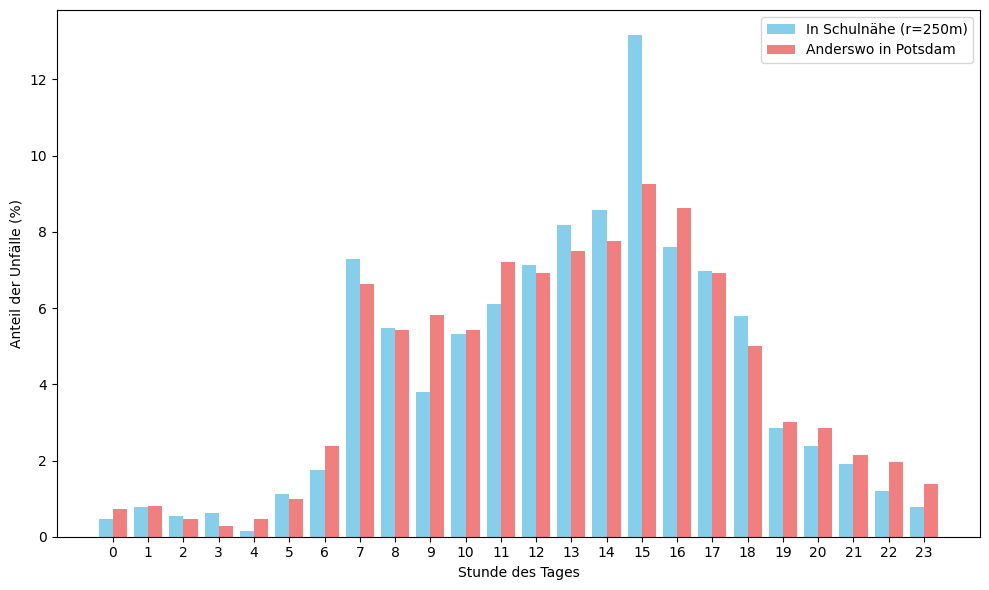

In [42]:
# Stacked histogram of accidents by hour of day, within and outside school areas (percent)
ufa_near_schools['HOUR'] = ufa_near_schools['USTUNDE']
ufa_not_schools['HOUR'] = ufa_not_schools['USTUNDE']
bins = np.arange(0, 25) - 0.5  # bins for histogram

# Calculate weights for normalization (convert to percentage)
weights_near = (np.ones(len(ufa_near_schools)) / len(ufa_near_schools)) * 100
weights_not = (np.ones(len(ufa_not_schools)) / len(ufa_not_schools)) * 100

plt.figure(figsize=(10, 6))
plt.hist(
    [ufa_near_schools['HOUR'], ufa_not_schools['HOUR']],
    bins=bins,
    weights=[weights_near, weights_not],
    label=[f'In Schulnähe (r={SCHOOL_RADIUS}m)', 'Anderswo in Potsdam'],
    color=['skyblue', 'lightcoral'],
)
plt.xlabel('Stunde des Tages')
plt.ylabel('Anteil der Unfälle (%)')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([
    (~ufa_near_schools['WEEKEND']).sum(), 
    (~ufa_not_schools['WEEKEND']).sum()
])
nobs = np.array([
    len(ufa_near_schools), 
    len(ufa_not_schools)
])
stat, p_z = proportions_ztest(count, nobs, alternative='larger')
p_hat = count / nobs
successes_ok = (nobs * p_hat) >= 10
failures_ok = (nobs * (1 - p_hat)) >= 10
assert all(successes_ok), "Normality assumption for z-test not met: expected successes < 10"
assert all(failures_ok), "Normality assumption for z-test not met: expected failures < 10"

if p_z < 0.1:
    print("\nZ-Test Weekday proportion Schools > Other")
    print("Z-Statistik:", stat, "p-Wert:", p_z)
    print(f"Der Anteil der Unfälle an Wochentagen ist signifikant größer in der Nähe von Schulen als anderswo (p={p_z:.4f})")
else:
    print(f"\nKein signifikanter Unterschied im Anteil der Unfälle an Wochentagen zwischen Schulen und anderen Orten (p={p_z:.4f})")


count = np.array([
    (ufa_near_schools['SCHULZEIT']).sum(), 
    (ufa_not_schools['SCHULZEIT']).sum()
])
nobs = np.array([
    len(ufa_near_schools), 
    len(ufa_not_schools)
])
stat, p_z = proportions_ztest(count, nobs, alternative='larger')
p_hat = count / nobs
successes_ok = (nobs * p_hat) >= 10
failures_ok = (nobs * (1 - p_hat)) >= 10
assert all(successes_ok), "Normality assumption for z-test not met: expected successes < 10"
assert all(failures_ok), "Normality assumption for z-test not met: expected failures < 10"

if p_z < 0.1:
    print("\nZ-Test School time proportion Schools > Other")
    print("Z-Statistik:", stat, "p-Wert:", p_z)
    print(f"Der Anteil der Unfälle während der Schulzeit ist signifikant größer in der Nähe von Schulen als anderswo (p={p_z:.4f})")
else:
    print(f"\nKein signifikanter Unterschied im Anteil der Unfälle während der Schulzeit zwischen Schulen und anderen Orten (p={p_z:.4f})")



Kein signifikanter Unterschied im Anteil der Unfälle an Wochentagen zwischen Schulen und anderen Orten (p=0.4500)

Z-Test School time proportion Schools > Other
Z-Statistik: 3.20644297288472 p-Wert: 0.0006719346931043624
Der Anteil der Unfälle während der Schulzeit ist signifikant größer in der Nähe von Schulen als anderswo (p=0.0007)


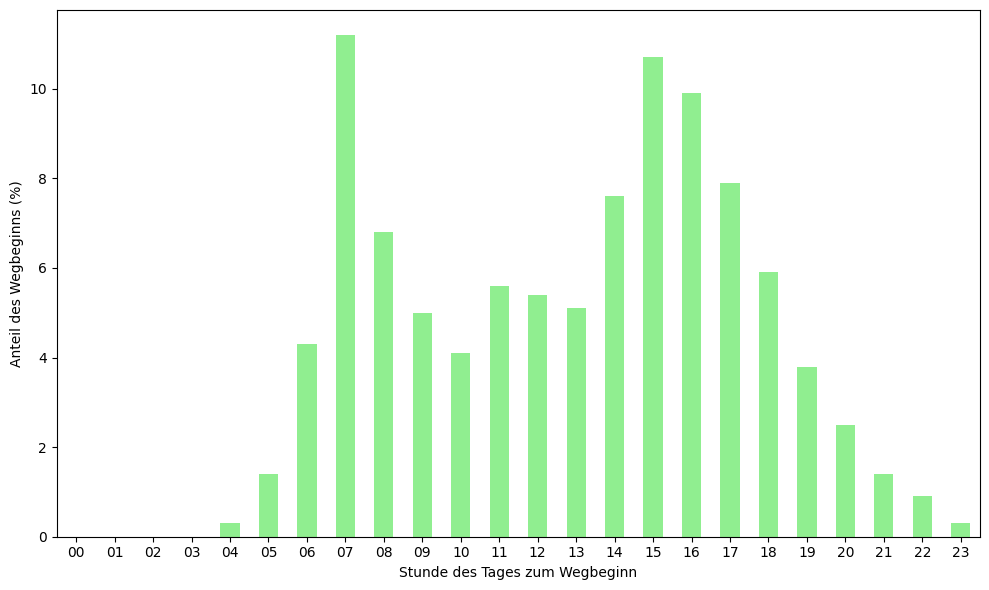

In [44]:
# stoßzeiten
data = """
Uhrzeit				Zu Fuß								Fahrrad												MIV						ÖV												Gesamt
00:00–01:00				0.0 %								0.0 %												0.0 %						0.0 %												0.0 %
01:01–02:00				0.0 %								0.0 %												0.0 %						0.0 %												0.0 %
02:01–03:00				0.0 %								0.0 %												0.0 %						0.0 %												0.0 %
03:01–04:00				0.0 %								0.0 %												0.0 %						0.1 %												0.0 %
04:01–05:00				0.1 %								0.1 %												0.5 %						0.5 %												0.3 %
05:01–06:00				0.4 %								0.9 %												3.1 %						1.1 %												1.4 %
06:01–07:00				2.3 %								2.9 %												6.7 %						6.4 %												4.3 %
07:01–08:00				9.0 %								13.5 %												10.3 %						12.9 %												11.2 %
08:01–09:00				5.8 %								9.3 %												6.0 %						6.1 %												6.8 %
09:01–10:00				5.0 %								4.1 %												4.2 %						7.3 %												5.0 %
10:01–11:00				5.9 %								2.6 %												4.7 %						2.8 %												4.1 %
11:01–12:00				5.9 %								6.3 %												4.3 %						6.0 %												5.6 %
12:01–13:00				9.1 %								3.0 %												4.1 %						4.6 %												5.4 %
13:01–14:00				6.5 %								4.7 %												3.7 %						5.2 %												5.1 %
14:01–15:00				7.4 %								7.7 %												7.1 %						8.3 %												7.6 %
15:01–16:00				10.3 %								10.8 %												9.8 %						12.3 %												10.7 %
16:01–17:00				9.3 %								11.7 %												8.9 %						9.7 %												9.9 %
17:01–18:00				8.2 %								7.5 %												8.8 %						6.8 %												7.9 %
18:01–19:00				5.6 %								6.2 %												7.3 %						3.7 %												5.9 %
19:01–20:00				4.3 %								4.1 %												3.9 %						2.6 %												3.8 %
20:01–21:00				2.1 %								2.8 %												3.6 %						1.4 %												2.5 %
21:01–22:00				1.8 %								1.1 %												1.2 %						1.3 %												1.4 %
22:01–23:00				0.9 %								0.5 %												1.5 %						0.6 %												0.9 %
23:01–24:00				0.3 %								0.3 %												0.6 %						0.1 %												0.3 %
"""
import pandas as pd
from io import StringIO
df_stosszeiten = pd.read_csv(StringIO(data), sep="\t")
# drop unamed columns
df_stosszeiten = df_stosszeiten.loc[:, ~df_stosszeiten.columns.str.contains('^Unnamed')]
df_stosszeiten["Uhrzeit"] = df_stosszeiten["Uhrzeit"].str.split("–").str[0].str.split(":").str[0]
df_stosszeiten = df_stosszeiten.set_index("Uhrzeit")
df_stosszeiten = df_stosszeiten.map(lambda x: float(x.replace(" %", "").replace(",", ".")))

# histogram of gesamt column
plt.figure(figsize=(10, 6))
df_stosszeiten['Gesamt'].plot(kind='bar', color='lightgreen')
plt.xlabel('Stunde des Tages zum Wegbeginn')
plt.ylabel('Anteil des Wegbeginns (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

         OBJECTID           UIDENTSTLAE  ULAND  UREGBEZ  UKREIS  UGEMEINDE  UJAHR  UMONAT  USTUNDE  UWOCHENTAG  ...                  LINREFY  XGCSWGS84  YGCSWGS84  STRZUSTAND                        geometry      OID_  IstStrassenzustand  PLST  WEEKEND  SCHULZEIT
9            10.0  12200125732105867410     12        0      54          0   2020       1       14           7  ...  5813905,674799999200000  13.072695  52.405129         1.0  POINT (777002.181 5813905.675)       NaN                 NaN   NaN    False       True
26           27.0  12200103732112825560     12        0      54          0   2020       1       21           6  ...  5812069,095899999100000  13.064967  52.388873         1.0  POINT (776578.464 5812069.096)       NaN                 NaN   NaN     True      False
54           55.0  12200128732104872460     12        0      54          0   2020       1        5           3  ...  5814309,901000000500000  13.054890  52.409378         1.0  POINT (775765.129 5814309.901)     

/tmp/ipykernel_358578/582959093.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


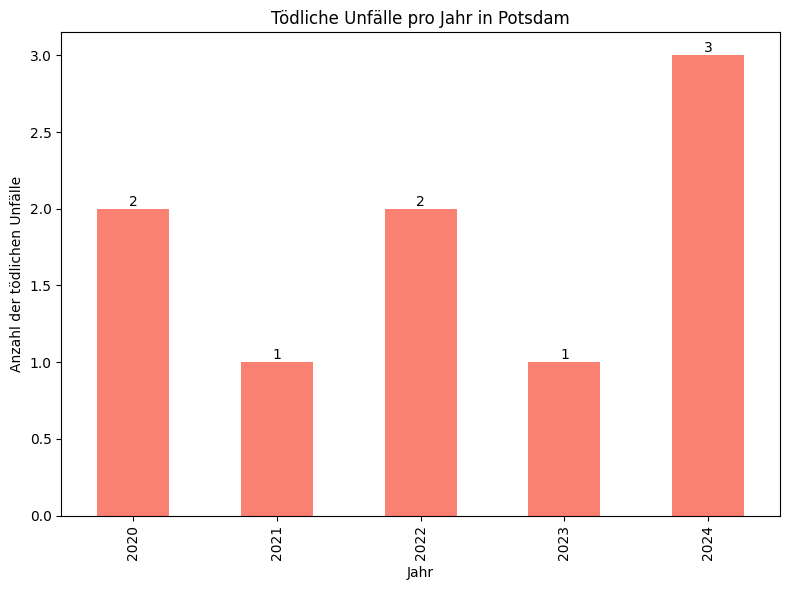

In [45]:
# tödliche unfälle pro jahr in gesamt potsdam
print(ufa)
print(ufa["UKATEGORIE"].value_counts())
toedliche_ufa = ufa[ufa["UKATEGORIE"] == 1]
print(toedliche_ufa)

fig, ax = plt.subplots(figsize=(8, 6))
toedliche_ufa['UJAHR'].value_counts().sort_index().plot(kind='bar', ax=ax, color='salmon')
ax.set_xlabel('Jahr')
ax.set_ylabel('Anzahl der tödlichen Unfälle')
ax.set_title('Tödliche Unfälle pro Jahr in Potsdam')
fig.tight_layout()
fig.show()

# add text to bars
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )